In [388]:
import pandas as pd
import numpy as np
import re
import scipy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import somersd


#Load data
def Train(path, nobs=10000):
    print("Loading %d observations..." %nobs)
    #Give path as a parameter
    train = pd.read_csv(path, sep=';', nrows=nobs)
    print(len(train.columns))
    #Get rid of artifacts 
    train = train.replace([-1], np.nan)
    train = train.replace(["-1.0"], np.nan)
    train = train.replace(["-1,0"], None)
    train = train.replace(["000"], None)
    return train

#Clear nans
def CleanNans(df):
    train_set=df
    #Find rows with more then 70 nans 
    list_nan_rows = []
    for i in range(len(train_set)):
        if ((train_set.iloc[i].isna().sum() >= 70)):
            list_nan_rows.append(i)
    train_set.drop(list_nan_rows, inplace = True) #drop them
    #Filling nan values in integer/real columns - use mean/average, depending on model's performance
    print("Filling nan values...")
    train_set["POLICY_DATA_1_INT"] = train_set["POLICY_DATA_1_INT"].fillna(int(train_set["POLICY_DATA_1_INT"].mean()))
    train_set["PERSON_6_INT"] = train_set["PERSON_6_INT"].fillna(int(train_set["PERSON_6_INT"].median()))
    train_set["CAR_1_INT"] = train_set["CAR_1_INT"].fillna(int(train_set["CAR_1_INT"].median()))
    #Filling nan values in nominal columns, using the dominant value as the benchmark (worked best in practise)
    for col in train_set.columns:
        if re.search("_NOM", col):
            train_set[col] = train_set[col].fillna(train_set[col].mode()[0]) 
    #Drop integer columns which are more then half empty
    for col in train_set.columns:
        if re.search("_INT", col):
            if train_set[col].isna().sum() >= len(train_set)/2:
                train_set.drop(columns = [col], inplace = True)
            else:
                train_set[col] = train_set[col].fillna(train_set[col].mode()[0])
    #Get list of real columns
    List_REAL = []
    for col in train_set.columns:
        if re.search("_REAL" ,col):
            List_REAL.append(col)
    #Change strings into reals
    for col in List_REAL:
        train_set[col] = train_set[col].apply(lambda x: x if x == None else float(x.split(",")[0]+"."+x.split(",")[1]))
        if train_set[col].isna().sum() >= len(train_set)/2:
            train_set.drop(columns = [col], inplace = True)
        elif (col == "CAR_4_REAL"):
            train_set[col] = train_set[col].fillna(train_set[col].median())
        else:
            train_set[col] = train_set[col].fillna(train_set[col].mean())  ###PERSON_4_REAL
    #Find nominal variables (again)
    List_NOM = []
    for col in train_set.columns:
        if re.search("_NOM" ,col):
            List_NOM.append(col)
    X = train_set[List_NOM]
    #Label Encoder for nominal variables
    le = preprocessing.LabelEncoder()
    X_2 = X.astype(str).apply(le.fit_transform)
    for col in X_2.columns:
        train_set[col] = X_2[col]
    return(train_set)

#Clear nans for test
def CleanNansTest(df):
    train_set=df
    #Filling nan values in integer/real columns - use mean/average, depending on model's performance
    print("Filling nan values...")
    train_set["POLICY_DATA_1_INT"] = train_set["POLICY_DATA_1_INT"].fillna(int(train_set["POLICY_DATA_1_INT"].mean()))
    train_set["PERSON_6_INT"] = train_set["PERSON_6_INT"].fillna(int(train_set["PERSON_6_INT"].median()))
    train_set["CAR_1_INT"] = train_set["CAR_1_INT"].fillna(int(train_set["CAR_1_INT"].median()))
    #Filling nan values in nominal columns, using the dominant value as the benchmark (worked best in practise)
    for col in train_set.columns:
        if re.search("_NOM", col):
            train_set[col] = train_set[col].fillna(train_set[col].mode()[0]) 
    #Drop integer columns which are more then half empty
    for col in train_set.columns:
        if re.search("_INT", col):
            if train_set[col].isna().sum() >= len(train_set)/2:
                train_set.drop(columns = [col], inplace = True)
            else:
                train_set[col] = train_set[col].fillna(train_set[col].mode()[0])
    #Get list of real columns
    List_REAL = []
    for col in train_set.columns:
        if re.search("_REAL" ,col):
            List_REAL.append(col)
    #Change strings into reals
    for col in List_REAL:
        train_set[col] = train_set[col].apply(lambda x: x if x == None else float(x.split(",")[0]+"."+x.split(",")[1]))
        if train_set[col].isna().sum() >= len(train_set)/2:
            train_set.drop(columns = [col], inplace = True)
        elif (col == "CAR_4_REAL"):
            train_set[col] = train_set[col].fillna(train_set[col].median())
        else:
            train_set[col] = train_set[col].fillna(train_set[col].mean())  ###PERSON_4_REAL
    #Find nominal variables (again)
    List_NOM = []
    for col in train_set.columns:
        if re.search("_NOM" ,col):
            List_NOM.append(col)
    X = train_set[List_NOM]
    #Label Encoder for nominal variables
    le = preprocessing.LabelEncoder()
    X_2 = X.astype(str).apply(le.fit_transform)
    for col in X_2.columns:
        train_set[col] = X_2[col]
    return(train_set)



#Split the dataset into dependent and explanatory variables
def SplitDatasetXY(train_set):
    train_set_X=train_set.drop('CLAIMS_REAL', axis=1)
    train_set_Y=train_set["CLAIMS_REAL"]
    return train_set_X,train_set_Y

#Make dummies for nominal variables 
def MakeDummies(df):
    print("Making dummies...")
    #List of nominal variables 
    List_NOM = []
    for col in df.columns:
        if re.search("_NOM" ,col):
            List_NOM.append(col)
    List_NOM.remove("CAR_10_NOM")#w/o CAR_10_NOM
    df=pd.get_dummies(df, columns=["CAR_10_NOM"],dummy_na=True) #nans are important information for CAR_10_NOM
    return pd.get_dummies(df, columns=List_NOM)

#Scale reals and integers
def ScaleData(X):
    print("Scaling data...")
    List_REAL = []
    List_NOM = []
    X_to_scale=X
    for col in X_to_scale.columns:
        if re.search("_NOM" ,col):
            List_NOM.append(col)
        else:
            List_REAL.append(col)
    X_nom=X_to_scale[List_NOM]
    X_to_scale=X_to_scale[List_REAL]
    scaler = StandardScaler()
    scaler.fit(X_to_scale)
    X_scaled = scaler.transform(X_to_scale)
    X_return=np.column_stack((X_scaled,X_nom))
    return X_return

#Do PCA, params:= n_comp,rand_stat
def PCA(X_scaled,n_comp=None, rand_stat=0):
    print("Doing PCA...")
    pca = PCA(n_components=n_comp, random_state=rand_stat)
    X_pca=pca.fit_transform(X_scaled)
    print("\nSize: ")
    print(X_pca.shape)
    # Get the eigenvalues
    print("Eigenvalues:")
    print(pca.explained_variance_)
    # Get explained variances
    print("Variances (Percentage):")
    print(pca.explained_variance_ratio_ * 100)
    print()
    # Make the scree plot
    plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
    plt.xlabel("Number of components (Dimensions)")
    plt.ylabel("Explained variance (%)")
    return(pd.DataFrame(X_pca))

#Oversample the claims (ones) using K-Means
def Smote(X, Y):
    oversample = SMOTE(random_state = 2)
    X, Y = oversample.fit_resample(X, Y)
    return X, Y

#Plot covariances of all variables
def PlotCovariance(X_pca):
    print("Plotting Covariance...")
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(X_pca.corr(), annot=True)
    
#Split dataset into train and test
def SplitDataset(X_scaled,Y,test_size=0.20, shuffle = True, random_state=2):
    print("Spliting Dataset into train and test...")
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.20, shuffle = True, random_state=2)
    return X_train_pca, X_test_pca, y_train, y_test

#Build Logit Model, includes hyperparametrisation, penalty method and class weight
def BuildLogisticRegression(X_train_pca, y_train,max_iter=2500, C = 1, penalty = "l1", class_weight = None):
    print("Building Logistic Regression...")
    # Initialize the logistic regression model
    clf = LogisticRegression(max_iter=max_iter, C = C, penalty = penalty, solver ="liblinear", class_weight = class_weight)
    # Train the model
    clf.fit(X_train_pca, y_train)
    return clf

#Make predictions based on model
def Predict(clf,X_test,y_test):
    print("Predicting...")
    y_pred = clf.predict(X_test) # Predictions
    y_true = y_test # True values
    y_prob=clf.predict_proba(X_test)
    return y_prob, y_pred

#Calculate accuracy, obsolete for our data
def MeasureAccuracy(y_train, X_train, y_true, y_pred):
    print("Train accuracy:", np.round(accuracy_score(y_train, clf.predict(X_train)), 2))
    print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))
    # Make the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    print("\nTest confusion_matrix")
    sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)

#Calculate gini (Somer's D statistic) based on provided data by two methods: 
#step-by-step, mathematician's way and using built-in function (just for sanity check)
def Somerek(prob, realised, prob_theirs=0):
    print("Calculating Gini...")
    total = len(realised)
    # Counting '1' labels in test data
    one_count = np.sum(realised)
    # Counting '0' labels in test data
    zero_count = total - one_count
    #Plot
    plt.figure(figsize = (10, 6))
    # x-axis ranges from 0 to size of train
    # y-axis ranges from 0 to the total claims
    #Plot given competing probabilities (if any are given)
    if prob_theirs.any():
        lm2 = [y for _, y in sorted(zip(prob_theirs,realised ), reverse = True)]
        x2 = np.arange(0, total + 1)
        y2 = np.append([0], np.cumsum(lm2))
        plt.plot(x2, y2, c = 'g', label = 'Their classifier', linewidth = 2)
    #Plot the random model's estimates
    plt.plot([0, total], [0, one_count], c = 'b',
             linestyle = '--', label = 'Random Model')
    #Plot our estimates
    lm = [y for _, y in sorted(zip(prob,realised ), reverse = True)]
    x = np.arange(0, total + 1)
    y = np.append([0], np.cumsum(lm))
    plt.plot(x, y, c = 'b', label = 'Our classifier', linewidth = 2)
    #Plot perfect model's estimate
    plt.plot([0, one_count, total], [0, one_count, one_count],
             c = 'red', linewidth = 2, label = 'Perfect Model')
    plt.legend()
    plt.show()
    #Calculate Somer's D the mathematician's way (best way)
    area=np.trapz(y, axis=0)
    area=area-total*one_count/2
    area2=total*one_count-one_count**2/2-total*one_count/2
    print("Gini of our model (step by step): ", area/area2)
    print("Gini of our model (built-in): ", scipy.stats.somersd(realised,prob).statistic,"pval: ", scipy.stats.somersd(realised,prob).pvalue)
    print("Gini of competing model (built-in) ", scipy.stats.somersd(realised,prob_theirs).statistic,"pval: ", scipy.stats.somersd(realised,prob_theirs).pvalue)

#Research variable's importance and intepretation
def FindImportance(Model, cols, imp_lvl):
    list_important=[]
    importance = Model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        if abs(v)>imp_lvl:
            print('Feature: %0d, Score: %.5f' % (i,v), cols[i])
            list_important.append(cols[i])
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    return list_important

#Get predictions on test dataset
def Test(Reg, important_vars, cols, path):
    test = pd.read_csv(path, delimiter = ";")#, nrows=1000
    test = test.replace([-1], np.nan)
    test = test.replace(["-1.0"], np.nan)
    test = test.replace(["-1,0"], None)
    test = test.replace(["000"], None)
    test = CleanNansTest(test)
    
    important_vars_for_test = important_vars
    important_vars_for_test.remove('CLAIMS_REAL')
    test = test[important_vars_for_test]
    
    test = MakeDummies(test)
    
    # Get missing columns in the training test
    missing_cols = set(cols) - set(test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test = test[cols]
    
    test_scal = ScaleData(test)
    y_test_prob = Reg.predict_proba(test_scal)
    return y_test_prob[:,1]
    


In [389]:
#Variables we selected, that are the most important for the modeling
important_vars=['CURRENT_MODEL_REAL', 'EXPOSURE_REAL', 'INS_HISTORY_14_INT', 'INS_HISTORY_15_INT', 'INS_HISTORY_16_INT', 'INS_HISTORY_17_INT', 'INS_HISTORY_20_REAL', 'INS_HISTORY_26_REAL', 'INS_HISTORY_27_REAL', 'INS_HISTORY_28_REAL', 'INS_HISTORY_6_INT', 'INS_HISTORY_8_REAL', 'PERSON_11_INT', 'PERSON_18_INT', 'PERSON_20_REAL', 'PERSON_35_INT', 'PERSON_37_INT', 'PERSON_38_INT', 'PERSON_40_INT', 'PERSON_52_INT', 'CLAIMS_REAL', 'CAR_11_NOM', 'CAR_12_NOM', 'CAR_13_NOM', 'CAR_14_NOM', 'CAR_17_NOM', 'CAR_2_NOM', 'CAR_30_NOM', 'CAR_3_NOM', 'CAR_8_NOM', 'INS_HISTORY_19_NOM', 'INS_HISTORY_31_NOM', 'OTHER_3_NOM', 'OTHER_4_NOM', 'PERSON_10_NOM', 'PERSON_13_NOM', 'PERSON_9_NOM', 'POLICY_DATA_3_NOM', 'POLICY_DATA_5_NOM', 'POLICY_DATA_9_NOM',"CAR_10_NOM"]

In [390]:
path1 = r"C:\Users\tadeu\OneDrive\Pulpit\DSCH_TRAIN_dataset.csv"
path1_test = r"C:\Users\tadeu\OneDrive\Pulpit\DSCH_TEST_dataset.csv"
path2 = r"DSCH_TRAIN_dataset.csv"
#Load data
train_set=Train(path1, 3829079)
#Clear it
train_set=CleanNans(train_set)
#Subset only important variables
train_set=train_set[important_vars]
#Make dummies
train_set=MakeDummies(train_set)
#Split it into X and Y
X,Y=SplitDatasetXY(train_set)








Loading 3829 observations...
139
Filling nan values...
Making dummies...


Scaling data...
Spliting Dataset into train and test...
Building Logistic Regression...
Spliting Dataset into train and test...
Predicting...
Calculating Gini...


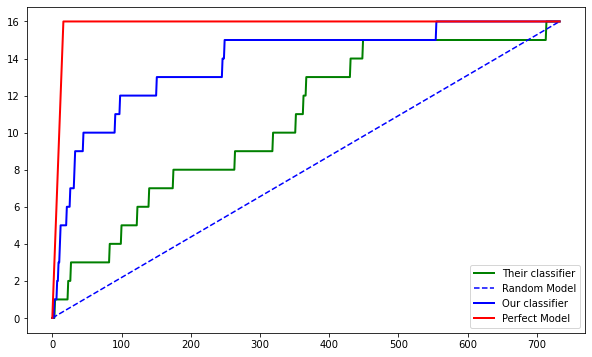

Gini of our model (step by step):  0.7466875871687587
Gini of our model (built-in):  0.7466875871687587 pval:  0.00026612757435817
Gini of competing model (built-in)  0.3378661087866109 pval:  0.02849082798679907


In [391]:
#Save columns for interpretation later
cols=X.columns.to_numpy()
#Scale the data
X_scal=ScaleData(X)
#Smote
X_smote,Y_smote = Smote(X_scal,Y)
#Split smote-produced values into train and test
X_train, X_test, Y_train, Y_test = SplitDataset(X_smote,Y_smote)
#Build Logit
Reg=BuildLogisticRegression(X_train,Y_train, C=1, penalty = "l1", class_weight = {0:0.9,1:0.1})
X_train, X_test, Y_train, Y_test = SplitDataset(X_scal,Y)
Y_prob, Y_pred=Predict(Reg, X_test, Y_test)   
#Assess gini and plot
Somerek(Y_prob[:,1],Y_test, X_test[:,0])


Feature: 0, Score: 0.28893 CURRENT_MODEL_REAL
Feature: 1, Score: -1.27951 EXPOSURE_REAL
Feature: 8, Score: -0.39567 INS_HISTORY_27_REAL
Feature: 9, Score: -1.00241 INS_HISTORY_28_REAL
Feature: 10, Score: -0.33375 INS_HISTORY_6_INT
Feature: 12, Score: -0.25020 PERSON_11_INT
Feature: 13, Score: -0.25114 PERSON_18_INT
Feature: 14, Score: 0.72675 PERSON_20_REAL
Feature: 15, Score: -0.49783 PERSON_35_INT
Feature: 16, Score: 1.48602 PERSON_37_INT
Feature: 17, Score: 0.33151 PERSON_38_INT
Feature: 18, Score: -2.28476 PERSON_40_INT
Feature: 23, Score: -0.82362 CAR_11_NOM_0
Feature: 24, Score: -0.31330 CAR_11_NOM_1
Feature: 25, Score: 0.29060 CAR_11_NOM_2
Feature: 30, Score: -0.45367 CAR_13_NOM_0
Feature: 32, Score: 1.59736 CAR_13_NOM_2
Feature: 33, Score: -0.78083 CAR_13_NOM_3
Feature: 34, Score: -0.51324 CAR_13_NOM_4
Feature: 35, Score: 0.32008 CAR_13_NOM_5
Feature: 36, Score: 0.77371 CAR_13_NOM_6
Feature: 38, Score: 1.33095 CAR_13_NOM_8
Feature: 42, Score: 0.45296 CAR_13_NOM_12
Feature: 47, 

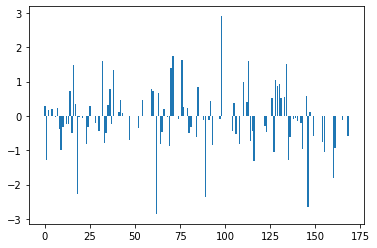

['CURRENT_MODEL_REAL',
 'EXPOSURE_REAL',
 'INS_HISTORY_27_REAL',
 'INS_HISTORY_28_REAL',
 'INS_HISTORY_6_INT',
 'PERSON_11_INT',
 'PERSON_18_INT',
 'PERSON_20_REAL',
 'PERSON_35_INT',
 'PERSON_37_INT',
 'PERSON_38_INT',
 'PERSON_40_INT',
 'CAR_11_NOM_0',
 'CAR_11_NOM_1',
 'CAR_11_NOM_2',
 'CAR_13_NOM_0',
 'CAR_13_NOM_2',
 'CAR_13_NOM_3',
 'CAR_13_NOM_4',
 'CAR_13_NOM_5',
 'CAR_13_NOM_6',
 'CAR_13_NOM_8',
 'CAR_13_NOM_12',
 'CAR_13_NOM_17',
 'CAR_13_NOM_22',
 'CAR_13_NOM_24',
 'CAR_13_NOM_29',
 'CAR_13_NOM_30',
 'CAR_13_NOM_32',
 'CAR_13_NOM_33',
 'CAR_13_NOM_34',
 'CAR_14_NOM_0',
 'CAR_14_NOM_4',
 'CAR_14_NOM_5',
 'CAR_14_NOM_6',
 'CAR_14_NOM_11',
 'CAR_14_NOM_12',
 'CAR_14_NOM_15',
 'CAR_14_NOM_16',
 'CAR_14_NOM_19',
 'CAR_14_NOM_20',
 'CAR_2_NOM_1',
 'CAR_2_NOM_4',
 'CAR_30_NOM_0',
 'CAR_3_NOM_2',
 'CAR_3_NOM_8',
 'CAR_3_NOM_9',
 'CAR_3_NOM_10',
 'CAR_3_NOM_12',
 'CAR_3_NOM_14',
 'CAR_8_NOM_1',
 'CAR_8_NOM_2',
 'CAR_8_NOM_3',
 'CAR_8_NOM_4',
 'CAR_8_NOM_5',
 'INS_HISTORY_19_NOM_2',
 

In [392]:
#Find how each column works 
FindImportance(Reg, cols,0.25)

In [382]:
#Variables we selected, that are the most important for the modeling
important_vars=['CURRENT_MODEL_REAL', 'EXPOSURE_REAL', 'INS_HISTORY_14_INT', 'INS_HISTORY_15_INT', 'INS_HISTORY_16_INT', 'INS_HISTORY_17_INT', 'INS_HISTORY_20_REAL', 'INS_HISTORY_26_REAL', 'INS_HISTORY_27_REAL', 'INS_HISTORY_28_REAL', 'INS_HISTORY_6_INT', 'INS_HISTORY_8_REAL', 'PERSON_11_INT', 'PERSON_18_INT', 'PERSON_20_REAL', 'PERSON_35_INT', 'PERSON_37_INT', 'PERSON_38_INT', 'PERSON_40_INT', 'PERSON_52_INT', 'CLAIMS_REAL', 'CAR_11_NOM', 'CAR_12_NOM', 'CAR_13_NOM', 'CAR_14_NOM', 'CAR_17_NOM', 'CAR_2_NOM', 'CAR_30_NOM', 'CAR_3_NOM', 'CAR_8_NOM', 'INS_HISTORY_19_NOM', 'INS_HISTORY_31_NOM', 'OTHER_3_NOM', 'OTHER_4_NOM', 'PERSON_10_NOM', 'PERSON_13_NOM', 'PERSON_9_NOM', 'POLICY_DATA_3_NOM', 'POLICY_DATA_5_NOM', 'POLICY_DATA_9_NOM',"CAR_10_NOM"]

In [383]:
prob = Test(Reg, important_vars, cols, path1_test)
print(prob)

Filling nan values...
Making dummies...
Scaling data...
[0.19600661 0.02194349 0.08465123 ... 0.18888716 0.26258573 0.09182408]


In [386]:
pd.DataFrame(prob).to_csv("output.csv")

In [387]:
len(prob)

3829079

NameError: name 'test' is not defined